### **Thanks to great works from Prem, Jasonczh, Chris, Jasonczh, Giba, Nin7a1, judith007,samu2505, tetsutani.**

## **This notebook mainly tuned the models and explain the reasons of doing these things. Hope my words can help you in this competition!**

In [1]:
import gc
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm
BASE = './12/'

def smape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * np.mean(smap)

def vsmape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * smap

In [2]:
census = pd.read_csv(BASE + 'census_starter.csv')
train = pd.read_csv(BASE + 'train.csv')
reaveal_test = pd.read_csv(BASE + 'revealed_test.csv')
train = pd.concat([train, reaveal_test]).sort_values(by=['cfips','first_day_of_month']).reset_index()
test = pd.read_csv(BASE + 'test.csv')
drop_index = (test.first_day_of_month == '2022-11-01') | (test.first_day_of_month == '2022-12-01')
test = test.loc[~drop_index,:]
sub = pd.read_csv(BASE + 'sample_submission.csv')
coords = pd.read_csv(BASE + "cfips_location.csv")
print(train.shape, test.shape, sub.shape)

train['istest'] = 0
test['istest'] = 1
raw = pd.concat((train, test)).sort_values(['cfips','row_id']).reset_index(drop=True)
raw = raw.merge(coords.drop("name", axis=1), on="cfips")

raw['state_i1'] = raw['state'].astype('category')
raw['county_i1'] = raw['county'].astype('category')
raw['first_day_of_month'] = pd.to_datetime(raw["first_day_of_month"])
raw['county'] = raw.groupby('cfips')['county'].ffill()
raw['state'] = raw.groupby('cfips')['state'].ffill()
raw["dcount"] = raw.groupby(['cfips'])['row_id'].cumcount()
raw['county_i'] = (raw['county'] + raw['state']).factorize()[0]
raw['state_i'] = raw['state'].factorize()[0]
raw['scale'] = (raw['first_day_of_month'] - raw['first_day_of_month'].min()).dt.days
raw['scale'] = raw['scale'].factorize()[0]
raw["year"] = raw["first_day_of_month"].dt.year
raw["month"] = raw["first_day_of_month"].dt.month
os.environ["CUDA_VISIBLE_DEVICES"]="0"


(128535, 8) (18810, 3) (25080, 2)


cnt=1
for state in raw['state'].unique():
    for i in raw.loc[(raw['state']==state)]['county'].unique():
        print(state, '  ',i)
        cnt+=1

# There are some anomalies, specially at timestep 18

In [3]:
raw.loc[raw['row_id'].str.contains('2022-07-01'),'microbusiness_density'] = 0.5*((raw.loc[raw['row_id'].str.contains('2022-06-01'),'microbusiness_density'].values)
                                                                                + (raw.loc[raw['row_id'].str.contains('2022-08-01'),'microbusiness_density'].values))

In [4]:
for o in tqdm(raw.cfips.unique()): 
    indices = (raw['cfips'] == o)  
    tmp = raw.loc[indices].copy().reset_index(drop=True)  
    
    var = tmp.microbusiness_density.values.copy()
    
    for i in range(37, 2, -1):
        
        thr = 0.10 * np.mean(var[:i]) 
        difa = var[i] - var[i - 1] 
        if (difa >= thr) or (difa <= -thr):  
            if difa > 0:
                var[:i] += difa - 0.003 
            else:
                var[:i] += difa + 0.003 
    var[0] = var[1] * 0.99
    raw.loc[indices, 'microbusiness_density'] = var


  0%|          | 0/3135 [00:00<?, ?it/s]

In [5]:
lag = 1
raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')['microbusiness_density'].shift(lag).bfill()
raw['dif'] = (raw['microbusiness_density'] / raw[f'mbd_lag_{lag}']).fillna(1).clip(0, None) - 1
raw.loc[(raw[f'mbd_lag_{lag}']==0), 'dif'] = 0
raw.loc[(raw[f'microbusiness_density']>0) & (raw[f'mbd_lag_{lag}']==0), 'dif'] = 1
raw['dif'] = raw['dif'].abs()
# raw.groupby('dcount')['dif'].sum().plot()

# SMAPE is a relative metric so target must be converted.

In [6]:
raw['target'] = raw.groupby('cfips')['microbusiness_density'].shift(-1)
raw['target'] = raw['target']/raw['microbusiness_density'] - 1

In [7]:
raw['lastactive'] = raw.groupby('cfips')['active'].transform('last')
raw['lastvalz'] = raw.groupby('cfips')['microbusiness_density'].transform('last')


# dt = raw.loc[raw.dcount==40].groupby('cfips')['microbusiness_density'].agg('last')
# raw['lastactive'].clip(0, 8000).hist(bins=30)

# Feature Engineering
> Try tuning this part

In [8]:
def build_features(raw, target='microbusiness_density', target_act='active_tmp', lags = 6):
    feats = []   

    for lag in range(1, lags):
        raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')[target].shift(lag)
        raw[f'act_lag_{lag}'] = raw.groupby('cfips')[target_act].diff(lag)
        feats.append(f'mbd_lag_{lag}')
        feats.append(f'act_lag_{lag}')
        
    lag = 1
    for window in [2, 3, 4, 5, 6, 8]:
        raw[f'mbd_rollmea{window}_{lag}'] = raw.groupby('cfips')[f'mbd_lag_{lag}'].transform(lambda s: s.rolling(window, min_periods=1).sum())  
        raw[f'mbd_rollmea_triang{window}_{lag}'] = raw.groupby('cfips')[f'mbd_lag_{lag}'].transform(lambda s: s.rolling(window, 
                                                                                                                 min_periods=1, 
                                                                                                                 win_type='triang').sum())
        raw[f'mbd_rollmea_gaussian{window}_{lag}'] = raw.groupby('cfips')[f'mbd_lag_{lag}'].transform(lambda s: s.rolling(window, 
                                                                                                                 min_periods=1, 
                                                                                                                 win_type='gaussian').sum(std=window))   
        
        feats.append(f'mbd_rollmea{window}_{lag}')
        feats.append(f'mbd_rollmea_triang{window}_{lag}')
        feats.append(f'mbd_rollmea_gaussian{window}_{lag}')
        
    lag = 1
    for window in [2, 3, 4]:
        raw[f'act_rollmea{window}_{lag}'] = raw.groupby('cfips')[f'act_lag_{lag}'].transform(lambda s: s.rolling(window, min_periods=1).sum())  
        raw[f'act_rollmea_triang{window}_{lag}'] = raw.groupby('cfips')[f'act_lag_{lag}'].transform(lambda s: s.rolling(window, 
                                                                                                                 min_periods=1, 
                                                                                                                 win_type='triang').sum())
        raw[f'act_rollmea_gaussian{window}_{lag}'] = raw.groupby('cfips')[f'act_lag_{lag}'].transform(lambda s: s.rolling(window, 
                                                                                                                 min_periods=1, 
                                                                                                                 win_type='gaussian').sum(std=window))   
        
        feats.append(f'act_rollmea{window}_{lag}')
        feats.append(f'act_rollmea_triang{window}_{lag}')
        feats.append(f'act_rollmea_gaussian{window}_{lag}')
    
    census_columns = list(census.columns)
    census_columns.remove( "cfips")
    
    raw = raw.merge(census, on="cfips", how="left")
    return raw, feats

In [9]:
values_list = [13101.0,48301.0,13265.0,28055.0,48033.0,48261.0,48269.0,31005.0,31009.0,31115.0,31165.0,48393.0,16033.0,31183.0,38087.0,2282.0,31007.0,31113.0,46003.0,46017.0]
Kmean_df = pd.read_csv('./' + 'k_means_graph_scaled_update.csv')
#Kmean_50 = pd.read_csv('./' + 'k_means_graph_50.csv')
#kmeans=Kmean_50[['cfips','K-means_Elbow']]
#kmeans.columns = ['cfips','Elbow']

In [10]:
raw = raw.merge(Kmean_df[['cfips','K-means_Silhouette','K-means_Elbow']], on="cfips", how="left")
#raw = raw.merge(kmeans[['cfips','Elbow']], on="cfips", how="left")

In [11]:
# Build Features based in lag of target
raw, feats = build_features(raw, 'target', 'active', lags = 8)
features = ['state_i']
features += feats
features += ['lng','lat','scale']
# print(features)
# raw.loc[raw.dcount==40, features].head(10)
features += ['K-means_Silhouette','K-means_Elbow']
features.remove('state_i')

Latitude and Longitude feature engineering from samu2505.

In [12]:
def rot(df):
    for angle in [15, 30, 45]:
        df[f'rot_{angle}_x'] = (np.cos(np.radians(angle)) * df['lat']) + \
                                (np.sin(np.radians(angle)) * df['lng'])
        
        df[f'rot_{angle}_y'] = (np.cos(np.radians(angle)) * df['lat']) - \
                                (np.sin(np.radians(angle)) * df['lng'])
        
    return df

#raw = rot(raw)

In [13]:
pd.options.display.max_columns = 200

In [14]:
#features += ['rot_15_x', 'rot_15_y', 'rot_30_x', 'rot_30_y', 'rot_45_x', 'rot_45_y']
features.remove('lat')
features.remove('lng')
#features.remove('SUMLEV')
#features.remove('DIVISION')

In [15]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(categories = 'auto', dtype = 'int32', drop = 'first',sparse=False)
df = raw[['K-means_Silhouette','K-means_Elbow']]
encoded_array = enc.fit_transform(df)
# convert the encoded array back into a dataframe
encoded_df = pd.DataFrame(encoded_array, columns=enc.get_feature_names_out(df.columns))
raw = pd.concat([raw, encoded_df],axis=1)
features_remove = ['K-means_Silhouette','K-means_Elbow']
for value in features_remove:
    while value in features:
        features.remove(value)

In [16]:
def append_col(col):
    desired_string = col
    for element in raw.columns:
        if desired_string in element:
            features.append(element)
    return features
features = append_col('K-means_Elbow_')
features = append_col('K-means_Silhouette_')

In [17]:
def get_model():
    from sklearn.ensemble import VotingRegressor
    import lightgbm as lgb
    import xgboost as xgb
    import catboost as cat
    from sklearn.pipeline import Pipeline
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.impute import KNNImputer    

# we should decrease the num_iterations of catboost
    cat_model = cat.CatBoostRegressor(
        iterations=2000,
        loss_function="MAPE",
        verbose=0,
        grow_policy='SymmetricTree',
        learning_rate=0.035,
        colsample_bylevel=0.8,
        max_depth=5,
        l2_leaf_reg=0.2,
        subsample=0.70,
        max_bin=4096,
    )

    return cat_model


def base_models():
    from sklearn.ensemble import VotingRegressor
    import lightgbm as lgb
    import xgboost as xgb
    import catboost as cat
    from sklearn.pipeline import Pipeline
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.impute import KNNImputer    
    
    # LGBM model
    params = {
    'n_iter': 300,
    'boosting_type': 'dart',
    'verbosity': -1,
    'objective': 'l1',
    'random_state': 42,
    'colsample_bytree': 0.8841279649367693,
    'colsample_bynode': 0.10142964450634374,
    'max_depth': 8,
    'learning_rate': 0.003647749926797374,
    'lambda_l2': 0.5,
    'num_leaves': 61,
    "seed": 42,
    'min_data_in_leaf': 213}

    lgb_model = lgb.LGBMRegressor(**params)
    
    xgb_model = xgb.XGBRegressor(
    objective='reg:pseudohubererror',
    tree_method="hist",
    n_estimators=795,
    learning_rate=0.0075,
    max_leaves = 17,
    subsample=0.50,
    colsample_bytree=0.50,
    max_bin=4096,
    n_jobs=2)

    # we should decrease the num_iterations of catboost
    cat_model = cat.CatBoostRegressor(
        iterations=2500,
        loss_function="MAPE",
        verbose=0,
        grow_policy='SymmetricTree',
        learning_rate=0.035,
        colsample_bylevel=0.8,
        max_depth=5,
        l2_leaf_reg=0.2,
        subsample=0.70,
        max_bin=4096,
    )
    
    models = {}
    models['xgb'] = xgb_model
    models['lgbm'] = lgb_model
    models['cat'] = cat_model

    return models

<AxesSubplot:>

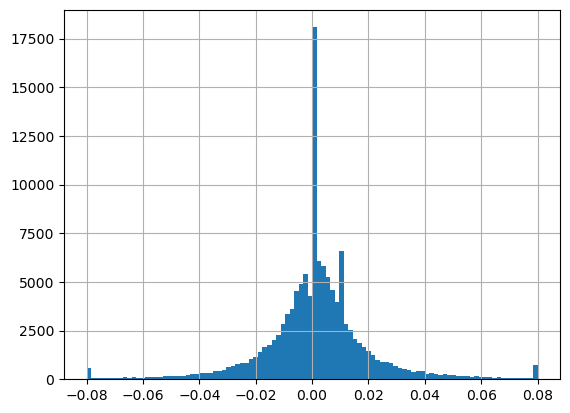

In [18]:
raw['target'].clip(-0.08, 0.08).hist(bins=100)

In [19]:
ACT_THR = 150
MONTH_1 = 39
MONTH_last = 40
start_MONTH = 18

In [20]:
train_indices = (raw.istest==0) & (raw.dcount  < 39) & (raw.dcount >= 20) & (raw.lastactive>ACT_THR) & (~raw['cfips'].isin(values_list))

In [21]:
raw['ypred_last'] = np.nan
raw['ypred'] = np.nan
raw['k'] = 1.
raw['microbusiness_density'].fillna(0, inplace = True)


for TS in range(MONTH_1, MONTH_last): #40):
    print(f'TS: {TS}')
    
    models = base_models()
    model0 = models['xgb']
    model1 = models['lgbm']
    model2 = models['cat']
            
    train_indices = (raw.istest==0) & (raw.dcount  < TS) & (raw.dcount >= start_MONTH) & (raw.lastactive>ACT_THR) & (~raw['cfips'].isin(values_list))
    valid_indices = (raw.istest==0) & (raw.dcount == TS) 
    
    # Train each of the models on the current TS
    model0.fit(
        raw.loc[train_indices, features],
        raw.loc[train_indices, 'target'].clip(-0.08, 0.08))
    
    model1.fit(
        raw.loc[train_indices, features],
        raw.loc[train_indices, 'target'].clip(-0.08, 0.08))
    
    model2.fit(
        raw.loc[train_indices, features],
        raw.loc[train_indices, 'target'].clip(-0.08, 0.08))
    

    tr_pred0 = model0.predict(raw.loc[train_indices, features])
    tr_pred1 = model1.predict(raw.loc[train_indices, features])
    tr_pred2 = model2.predict(raw.loc[train_indices, features])
    train_preds = np.column_stack((tr_pred0, tr_pred1, tr_pred2))
    
    meta_model = get_model() 
    meta_model.fit(train_preds, raw.loc[train_indices, 'target'].clip(-0.08, 0.08))
    
    val_preds0 = model0.predict(raw.loc[valid_indices, features])
    val_preds1 = model1.predict(raw.loc[valid_indices, features])
    val_preds2 = model2.predict(raw.loc[valid_indices, features])
    valid_preds = np.column_stack((val_preds0, val_preds1, val_preds2))
    
    ypred = meta_model.predict(valid_preds)
    raw.loc[valid_indices, 'k'] = ypred + 1
    raw.loc[valid_indices,'k'] = raw.loc[valid_indices,'k'] * raw.loc[valid_indices,'microbusiness_density']

    # Validate
    lastval = raw.loc[raw.dcount==TS, ['cfips', 'microbusiness_density']].set_index('cfips').to_dict()['microbusiness_density']
    dt = raw.loc[raw.dcount==TS, ['cfips', 'k']].set_index('cfips').to_dict()['k']
    
    df = raw.loc[raw.dcount==(TS+1), 
                 ['cfips', 'microbusiness_density', 'state', 'lastactive', 'mbd_lag_1']].reset_index(drop=True)
    df['pred'] = df['cfips'].map(dt)
    df['lastval'] = df['cfips'].map(lastval)
    
#     df.loc[df['lastval'].isnull(), 'lastval'] = df.loc[df['lastval'].isnull(), 'microbusiness_density']    
    
    df.loc[df['lastactive']<=ACT_THR, 'pred'] = df.loc[df['lastactive']<=ACT_THR, 'lastval']
    df.loc[df['cfips'].isin(values_list), 'pred'] = df.loc[df['cfips'].isin(values_list), 'lastval']
        
    raw.loc[raw.dcount==(TS+1), 'ypred'] = df['pred'].values
    raw.loc[raw.dcount==(TS+1), 'ypred_last'] = df['lastval'].values
    
    print('Last Value SMAPE:', smape(df['microbusiness_density'], df['lastval']) )
    print('SMAPE:', smape(df['microbusiness_density'], df['pred']))
    print()

ind = (raw.dcount > MONTH_1)&(raw.dcount <= MONTH_last)

print('SMAPE:', smape( raw.loc[ind, 'microbusiness_density'],  raw.loc[ind, 'ypred']))
print('Last Value SMAPE:', smape( raw.loc[ind, 'microbusiness_density'],  raw.loc[ind, 'ypred_last']))

TS: 39


C:\Users\82108\AppData\Roaming\Python\Python37\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] seed is set=42, random_state=42 will be ignored. Current value: seed=42
[LightGBM] [Warning] min_data_in_leaf is set=213, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=213
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] num_iterations is set=300, n_iter=300 will be ignored. Current value: num_iterations=300
Last Value SMAPE: 1.889206717018118
SMAPE: 1.8628518143809991

SMAPE: 1.8628518143809991
Last Value SMAPE: 1.889206717018118


In [22]:
raw.loc[train_indices, features]

,mbd_lag_1,act_lag_1,mbd_lag_2,act_lag_2,mbd_lag_3,act_lag_3,mbd_lag_4,act_lag_4,mbd_lag_5,act_lag_5,mbd_lag_6,act_lag_6,mbd_lag_7,act_lag_7,mbd_rollmea2_1,mbd_rollmea_triang2_1,mbd_rollmea_gaussian2_1,mbd_rollmea3_1,mbd_rollmea_triang3_1,mbd_rollmea_gaussian3_1,mbd_rollmea4_1,mbd_rollmea_triang4_1,mbd_rollmea_gaussian4_1,mbd_rollmea5_1,mbd_rollmea_triang5_1,mbd_rollmea_gaussian5_1,mbd_rollmea6_1,mbd_rollmea_triang6_1,mbd_rollmea_gaussian6_1,mbd_rollmea8_1,mbd_rollmea_triang8_1,mbd_rollmea_gaussian8_1,act_rollmea2_1,act_rollmea_triang2_1,act_rollmea_gaussian2_1,act_rollmea3_1,act_rollmea_triang3_1,act_rollmea_gaussian3_1,act_rollmea4_1,act_rollmea_triang4_1,act_rollmea_gaussian4_1,scale,K-means_Elbow_1,K-means_Elbow_2,K-means_Elbow_3,K-means_Elbow_4,K-means_Elbow_5,K-means_Elbow_6,K-means_Elbow_7,K-means_Silhouette_1
18,0.053902,67.0,-0.018422,54.0,-0.011802,39.0,-0.048653,-26.0,-0.003729,-31.0,0.009789,-18.0,0.029457,20.0,0.035479,0.017740,0.034388,0.023678,0.002628,0.021403,-0.024975,-0.021356,-0.025096,-0.028703,-0.039794,-0.031233,-0.018914,-0.050839,-0.023319,0.031921,-0.033543,0.024662,54.0,27.0,52.338595,39.0,13.0,36.189892,-26.0,-20.50,-25.917897,18,0,0,0,0,0,0,0,0
19,0.012214,16.0,0.053902,83.0,-0.018422,70.0,-0.011802,55.0,-0.048653,-10.0,-0.003729,-15.0,0.009789,-2.0,0.066116,0.033058,0.064081,0.047693,0.050798,0.048029,0.035892,0.026713,0.035587,-0.012761,-0.002502,-0.010793,-0.016490,-0.021148,-0.017252,0.022757,-0.037649,0.016422,83.0,41.5,80.446358,70.0,68.5,69.837878,55.0,40.75,54.511871,19,0,0,0,0,0,0,0,0
20,0.025641,34.0,0.012214,50.0,0.053902,117.0,-0.018422,104.0,-0.011802,89.0,-0.048653,24.0,-0.003729,19.0,0.037855,0.018927,0.036690,0.091757,0.051985,0.087458,0.073334,0.051391,0.072330,0.061533,0.054376,0.060591,0.012880,0.025937,0.014657,0.018940,-0.015555,0.015270,50.0,25.0,48.461662,117.0,66.5,111.541906,104.0,67.50,101.928241,20,0,0,0,0,0,0,0,0
21,0.000735,1.0,0.025641,35.0,0.012214,51.0,0.053902,118.0,-0.018422,105.0,-0.011802,90.0,-0.048653,25.0,0.026376,0.013188,0.025565,0.038590,0.032116,0.037890,0.092492,0.042050,0.088488,0.074070,0.059347,0.073854,0.062268,0.056861,0.062737,0.009887,0.022299,0.011180,35.0,17.5,33.923163,51.0,42.5,50.081311,118.0,54.50,112.993866,21,0,0,0,0,0,0,0,0
22,-0.001470,-2.0,0.000735,-1.0,0.025641,33.0,0.012214,49.0,0.053902,116.0,-0.018422,103.0,-0.011802,88.0,-0.000734,-0.000367,-0.000712,0.024907,0.012821,0.023601,0.037121,0.022468,0.036186,0.091022,0.051751,0.086735,0.072600,0.055549,0.072442,0.012146,0.051948,0.016993,-1.0,-0.5,-0.969233,33.0,17.0,31.270703,49.0,29.75,47.777063,22,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147285,0.061798,11.0,-0.011111,9.0,-0.010989,7.0,-0.005465,6.0,0.000000,6.0,-0.010156,4.0,0.000000,4.0,0.050687,0.025343,0.049127,0.039698,0.014293,0.036952,0.034233,-0.002492,0.030580,0.034233,-0.001440,0.029810,0.024077,-0.010660,0.020182,0.002913,-0.017085,0.000113,9.0,4.5,8.723099,7.0,2.5,6.513635,6.0,-0.50,5.352153,34,0,0,0,1,0,0,0,1
147286,0.031746,6.0,0.061798,17.0,-0.011111,15.0,-0.010989,13.0,-0.005465,12.0,0.000000,12.0,-0.010156,10.0,0.093544,0.046772,0.090666,0.082433,0.072115,0.081318,0.071444,0.043204,0.069640,0.065979,0.031522,0.062952,0.065979,0.015041,0.061683,0.055823,0.001993,0.050690,17.0,8.5,16.476965,15.0,13.0,14.783838,13.0,7.75,12.658371,35,0,0,0,1,0,0,0,1
147287,-0.005128,-1.0,0.031746,5.0,0.061798,16.0,-0.011111,14.0,-0.010989,12.0,-0.005465,11.0,0.000000,11.0,0.026618,0.013309,0.025799,0.088416,0.060081,0.085353,0.077304,0.066098,0.077679,0.066315,0.070182,0.067146,0.060851,0.050852,0.060917,0.050695,0.025865,0.049638,5.0,2.5,4.846166,16.0,11.0,15.459595,14.0,12.00,14.071397,36,0,0,0,1,0,0,0,1
147288,0.000000,0.0,-0.005128,-1.0,0.031746,5.0,0.061798,16.0,-0.011111,14.0,-0.010989,12.0,-0.005465,11.0,-0.005128,-0.002564,-0.004970,0.026618,0.010745,0.0

In [23]:
raw[raw['microbusiness_density'].isnull()]

,index,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,lng,lat,state_i1,county_i1,dcount,county_i,state_i,scale,year,month,mbd_lag_1,dif,target,lastactive,lastvalz,K-means_Silhouette,K-means_Elbow,act_lag_1,mbd_lag_2,act_lag_2,mbd_lag_3,act_lag_3,mbd_lag_4,act_lag_4,mbd_lag_5,act_lag_5,mbd_lag_6,act_lag_6,mbd_lag_7,act_lag_7,mbd_rollmea2_1,mbd_rollmea_triang2_1,mbd_rollmea_gaussian2_1,mbd_rollmea3_1,mbd_rollmea_triang3_1,mbd_rollmea_gaussian3_1,mbd_rollmea4_1,mbd_rollmea_triang4_1,mbd_rollmea_gaussian4_1,mbd_rollmea5_1,mbd_rollmea_triang5_1,mbd_rollmea_gaussian5_1,mbd_rollmea6_1,mbd_rollmea_triang6_1,mbd_rollmea_gaussian6_1,mbd_rollmea8_1,mbd_rollmea_triang8_1,mbd_rollmea_gaussian8_1,act_rollmea2_1,act_rollmea_triang2_1,act_rollmea_gaussian2_1,act_rollmea3_1,act_rollmea_triang3_1,act_rollmea_gaussian3_1,act_rollmea4_1,act_rollmea_triang4_1,act_rollmea_gaussian4_1,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,pct_college_2021,pct_foreign_born_2017,pct_foreign_born_2018,pct_foreign_born_2019,pct_foreign_born_2020,pct_foreign_born_2021,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021,K-means_Silhouette_1,K-means_Elbow_1,K-means_Elbow_2,K-means_Elbow_3,K-means_Elbow_4,K-means_Elbow_5,K-means_Elbow_6,K-means_Elbow_7,ypred_last,ypred,k


In [24]:
TS = 40
print(TS)

model0 = get_model()

train_indices = (raw.istest==0) & (raw.dcount  < TS) & (raw.dcount >= start_MONTH) & (raw.lastactive>ACT_THR) & (~raw['cfips'].isin(values_list))
valid_indices = (raw.dcount == TS)

model0.fit(
        raw.loc[train_indices, features],
        raw.loc[train_indices, 'target'].clip(-0.08, 0.08))
    
model1.fit(
    raw.loc[train_indices, features],
    raw.loc[train_indices, 'target'].clip(-0.08, 0.08))

model2.fit(
    raw.loc[train_indices, features],
    raw.loc[train_indices, 'target'].clip(-0.08, 0.08))


tr_pred0 = model0.predict(raw.loc[train_indices, features])
tr_pred1 = model1.predict(raw.loc[train_indices, features])
tr_pred2 = model2.predict(raw.loc[train_indices, features])
train_preds = np.column_stack((tr_pred0, tr_pred1, tr_pred2))

meta_model = get_model() 
meta_model.fit(train_preds, raw.loc[train_indices, 'target'].clip(-0.08, 0.08))

val_preds0 = model0.predict(raw.loc[valid_indices, features])
val_preds1 = model1.predict(raw.loc[valid_indices, features])
val_preds2 = model2.predict(raw.loc[valid_indices, features])
valid_preds = np.column_stack((val_preds0, val_preds1, val_preds2))

ypred = meta_model.predict(valid_preds)

# ypred = model0.predict(raw.loc[valid_indices, features])
raw.loc[valid_indices, 'k'] = ypred + 1.
raw.loc[valid_indices,'k'] = raw.loc[valid_indices,'k'] * raw.loc[valid_indices,'microbusiness_density']

# Validate
lastval = raw.loc[raw.dcount==TS, ['cfips', 'microbusiness_density']].set_index('cfips').to_dict()['microbusiness_density']
dt = raw.loc[raw.dcount==TS, ['cfips', 'k']].set_index('cfips').to_dict()['k']

40


C:\Users\82108\AppData\Roaming\Python\Python37\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] seed is set=42, random_state=42 will be ignored. Current value: seed=42
[LightGBM] [Warning] min_data_in_leaf is set=213, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=213
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] num_iterations is set=300, n_iter=300 will be ignored. Current value: num_iterations=300


In [25]:
df = raw.loc[raw.dcount==(TS+1), ['cfips', 'microbusiness_density', 'state', 'lastactive', 'mbd_lag_1']].reset_index(drop=True)

In [26]:
df['pred'] = df['cfips'].map(dt)
df['lastval'] = df['cfips'].map(lastval)

df.loc[df['lastactive']<=ACT_THR, 'pred'] = df.loc[df['lastactive']<=ACT_THR, 'lastval']
df.loc[df['cfips'].isin(values_list), 'pred'] = df.loc[df['cfips'].isin(values_list), 'lastval']

raw.loc[raw.dcount==(TS+1), 'ypred'] = df['pred'].values
raw.loc[raw.dcount==(TS+1), 'ypred_last'] = df['lastval'].values

In [27]:
#mask = (raw.lastactive > 150) & (raw.dcount==(TS+1)) & (~raw['cfips'].isin(values_list))
#k = 0.1
#raw.loc[mask, 'ypred'] = k * 1.005 * raw.loc[mask, 'ypred_last'] + (1-k) * raw.loc[mask, 'ypred']

In [28]:
dt = raw.loc[raw.dcount==41, ['cfips', 'ypred']].set_index('cfips').to_dict()['ypred']
test = raw.loc[raw.istest==1, ['row_id', 'cfips','microbusiness_density']].copy()
test['microbusiness_density'] = test['cfips'].map(dt)
test = test[['row_id','microbusiness_density']]

In [29]:
sample_sub = pd.read_csv(BASE + 'revealed_test.csv')
sub_index = (sample_sub.first_day_of_month == '2022-11-01') | (sample_sub.first_day_of_month  == '2022-12-01')
test1 = pd.concat([sample_sub.loc[sub_index, :].drop([i for i  in sample_sub.columns if i !='row_id' and i != 'microbusiness_density'],axis=1).fillna(2), test])

In [30]:
test1 = test1.fillna(2)  # fill anything you want 

In [31]:
COLS = ['GEO_ID','NAME','S0101_C01_026E']

In [32]:
df2017 = pd.read_csv('./12/ACSST5Y2017.S0101-Data.csv',usecols=COLS, dtype = 'object')
df2017 = df2017.iloc[1:]
df2017['S0101_C01_026E'] = df2017['S0101_C01_026E'].astype('int')

In [33]:
df2018 = pd.read_csv('./12/ACSST5Y2018.S0101-Data.csv',usecols=COLS, dtype = 'object')
df2018 = df2018.iloc[1:]
df2018['S0101_C01_026E'] = df2018['S0101_C01_026E'].astype('int')

In [34]:
df2019 = pd.read_csv('./12/ACSST5Y2019.S0101-Data.csv',usecols=COLS, dtype = 'object')
df2019 = df2019.iloc[1:]
df2019['S0101_C01_026E'] = df2019['S0101_C01_026E'].astype('int')

In [35]:
df2020 = pd.read_csv('./12/ACSST5Y2020.S0101-Data.csv',usecols=COLS, dtype = 'object')
df2020 = df2020.iloc[1:]
df2020['S0101_C01_026E'] = df2020['S0101_C01_026E'].astype('int')

In [36]:
df2021 = pd.read_csv('./12/ACSST5Y2021.S0101-Data.csv',usecols=COLS, dtype = 'object')
df2021 = df2021.iloc[1:]
df2021['S0101_C01_026E'] = df2021['S0101_C01_026E'].astype('int')

In [37]:
test1['cfips'] = test1.row_id.apply(lambda x: int(x.split('_')[0]))

In [38]:
df2017['cfips'] = df2017.GEO_ID.apply(lambda x: int(x.split('US')[-1]) )
adult2017 = df2017.set_index('cfips').S0101_C01_026E.to_dict()


df2018['cfips'] = df2018.GEO_ID.apply(lambda x: int(x.split('US')[-1]) )
adult2018 = df2018.set_index('cfips').S0101_C01_026E.to_dict()

df2019['cfips'] = df2019.GEO_ID.apply(lambda x: int(x.split('US')[-1]) )
adult2019 = df2019.set_index('cfips').S0101_C01_026E.to_dict()

df2020['cfips'] = df2020.GEO_ID.apply(lambda x: int(x.split('US')[-1]) )
adult2020 = df2020.set_index('cfips').S0101_C01_026E.to_dict()

df2021['cfips'] = df2021.GEO_ID.apply(lambda x: int(x.split('US')[-1]) )
adult2021 = df2021.set_index('cfips').S0101_C01_026E.to_dict()

test1['adult2017'] = test1.cfips.map(adult2017)
test1['adult2018'] = test1.cfips.map(adult2018)
test1['adult2019'] = test1.cfips.map(adult2019)
test1['adult2020'] = test1.cfips.map(adult2020)
test1['adult2021'] = test1.cfips.map(adult2021)

In [39]:
x=22
test1['adult2022'] = round(((((test1['adult2021']-test1['adult2020']) / (21-20)) * (x-21) + test1['adult2021']) +
                        (((test1['adult2021']-test1['adult2019']) / (21-19)) * (x-21) + test1['adult2021'])
                        #(((test1['adult2021']-test1['adult2018']) / (21-18)) * (x-21) + test1['adult2021'])
                        #(((test1['adult2021']-test1['adult2017']) / (21-17)) * (x-21) + test1['adult2021'])
                       ) / 2, 0)

In [40]:
test1['slope'] = test1['adult2021']/test1['adult2022']
test1['micro21'] = test1.adult2020 / test1.adult2021

In [41]:
pd.options.display.max_rows = 200

In [42]:
test1[3135*2:].loc[test1[3135*2:]['row_id'].str.contains('2023-01-01')]

,row_id,microbusiness_density,cfips,adult2017,adult2018,adult2019,adult2020,adult2021,adult2022,slope,micro21
41,1001_2023-01-01,3.489387,1001,41527,41831,42175,42496,44438,45975.0,0.966569,0.956299
88,1003_2023-01-01,8.287780,1003,158361,162430,166595,171296,178105,184387.0,0.965930,0.961770
135,1005_2023-01-01,1.260065,1005,20687,20346,20054,19804,19995,20076.0,0.995965,0.990448
182,1007_2023-01-01,1.297577,1007,17852,17868,17862,17790,17800,17790.0,1.000562,0.999438
229,1009_2023-01-01,1.864720,1009,44102,44177,44292,44383,45201,45837.0,0.986125,0.981903
...,...,...,...,...,...,...,...,...,...,...,...
147151,56037_2023-01-01,2.878647,56037,32571,32308,31974,32049,31514,31132.0,1.012270,1.016977
147198,56039_2023-01-01,26.394215,56039,18488,18625,18842,19164,19169,19253.0,0.995637,0.999739
147245,56041_2023-01-01,4.074274,56041,14614,14538,14506,14516,14641,14737.0,0.993486,0.991462
147292,56043_2023-01-01,3.055897,56043,6223,6187,6049,6045,6000,5965.0,1.005868,1.007500


In [43]:
#pd.options.display.max_rows = None

df = test1[3135*2:].loc[test1[3135*2:]['row_id'].str.contains('2023-01-01')]
df.loc[(df['micro21']<=0.9)|(df['micro21']>=1.1),'micro21'] = df['slope']
df.loc[(df['micro21']<=0.9)|(df['micro21']>=1.1)]

In [44]:
test1['microbusiness_density'] = test1.microbusiness_density * test1.micro21

In [45]:
test1[['row_id','microbusiness_density']].to_csv('sub_.csv',index=False)

In [46]:
test1[3135*2:].loc[test1[3135*2:]['row_id'].str.contains('2023-01-01')] #micro21

,row_id,microbusiness_density,cfips,adult2017,adult2018,adult2019,adult2020,adult2021,adult2022,slope,micro21
41,1001_2023-01-01,3.336896,1001,41527,41831,42175,42496,44438,45975.0,0.966569,0.956299
88,1003_2023-01-01,7.970936,1003,158361,162430,166595,171296,178105,184387.0,0.965930,0.961770
135,1005_2023-01-01,1.248028,1005,20687,20346,20054,19804,19995,20076.0,0.995965,0.990448
182,1007_2023-01-01,1.296848,1007,17852,17868,17862,17790,17800,17790.0,1.000562,0.999438
229,1009_2023-01-01,1.830974,1009,44102,44177,44292,44383,45201,45837.0,0.986125,0.981903
...,...,...,...,...,...,...,...,...,...,...,...
147151,56037_2023-01-01,2.927516,56037,32571,32308,31974,32049,31514,31132.0,1.012270,1.016977
147198,56039_2023-01-01,26.387331,56039,18488,18625,18842,19164,19169,19253.0,0.995637,0.999739
147245,56041_2023-01-01,4.039489,56041,14614,14538,14506,14516,14641,14737.0,0.993486,0.991462
147292,56043_2023-01-01,3.078816,56043,6223,6187,6049,6045,6000,5965.0,1.005868,1.007500


In [47]:
test1[['row_id','microbusiness_density']]

,row_id,microbusiness_density
0,1001_2022-11-01,3.292227
1,1001_2022-12-01,3.319231
2,1003_2022-11-01,7.941945
3,1003_2022-12-01,7.935207
4,1005_2022-11-01,1.235309
...,...,...
147340,56045_2023-02-01,1.836698
147341,56045_2023-03-01,1.836698
147342,56045_2023-04-01,1.836698
147343,56045_2023-05-01,1.836698
